In [2]:
import os
import matplotlib.pyplot as plt
import torch
from PIL import Image, ImageDraw
import pickle
import json
from tqdm import tqdm

import clip
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

In [3]:
class RefCOCOg(Dataset):
    """
    Args:
        dataset: a list of dictionaries containing:
        {
            'file_name': # path of the image, images will be loaded on the fly
            'caption': # referring caption
            'ann_id': # annotation ID (one per caption), taken from 'file_name'
            'bbox': # coordinates (xmin, ymin, xmax, ymax) of the bounding box
        }
    """

    def __init__(self, refs, annotations, split="train"):

        self.dataset = [{"file_name": os.path.join("./refcocog/images/", f'{"_".join(elem["file_name"].split("_")[:3])}.jpg'),
                            "caption": clip.tokenize(elem["sentences"][0]["raw"]),
                            "ann_id": int(elem["file_name"].split("_")[3][:-4]),
                            "bbox": annotations[int(elem["file_name"].split("_")[3][:-4])]}
                        for elem in [d for d in refs if d["split"]==split]]
    """
    def __init__(self, refs, annotations, tokenizer, split="train"):

        self.dataset = [{"file_name": os.path.join("./refcocog/images/", f'{"_".join(elem["file_name"].split("_")[:3])}.jpg'),
                            "caption": tokenizer(
                                    elem["sentences"][0]["raw"], padding=True, truncation=True, max_length=200
                                ),
                            "ann_id": int(elem["file_name"].split("_")[3][:-4]),
                            "bbox": annotations[int(elem["file_name"].split("_")[3][:-4])]}
                        for elem in [d for d in refs if d["split"]==split]]
    """
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

    def __call__(self, idx):
        print(json.dumps(self.dataset[idx], indent=4))

In [4]:
with open("./refcocog/annotations/refs(umd).p", "rb") as fp:
  refs = pickle.load(fp)

# 'annotations' will be a dict object mapping the 'annotation_id' to the 'bbox' to make search faster
with open("./refcocog/annotations/instances.json", "rb") as fp:
  data = json.load(fp)
  annotations = dict(sorted({ann["id"]: ann["bbox"] for ann in data["annotations"]}.items()))

FileNotFoundError: [Errno 2] No such file or directory: '../refcocog/annotations/refs(umd).p'

# Text Encoder

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = DistilBertModel(config=DistilBertConfig())

        for p in self.model.parameters():
            p.requires_grad = True

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

{'file_name': '../refcocog/images/COCO_train2014_000000245806.jpg', 'caption': tensor([[49406,   518,   786,  6283,   518, 15308,   269, 49407,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32), 'ann_id': 513409, 'bbox': [139.82, 89.37, 223.42, 498.74]}


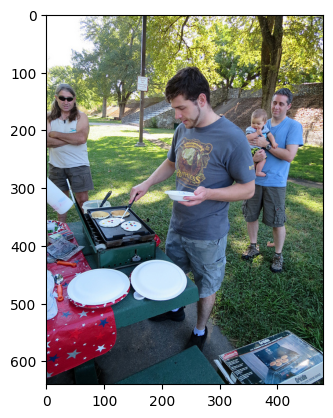

In [ ]:
#tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
dataset_train = RefCOCOg(refs, annotations, split="train")
plt.imshow(Image.open(dataset_train[7341]["file_name"]))
print(dataset_train[7341])
dataloader_train = DataLoader(dataset_train, batch_size=1, collate_fn=collate_fn)


{'file_name': '../refcocog/images/COCO_train2014_000000478885.jpg', 'caption': tensor([[49406,   320,  3055, 14345, 11639,   652, 49407,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32), 'ann_id': 124383, 'bbox': [338.8, 82.19, 147.34, 157.37]}


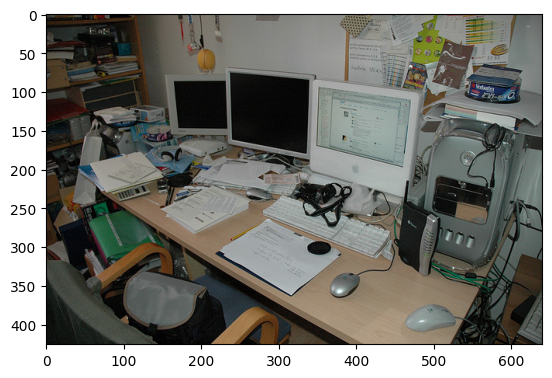

In [ ]:
dataset_test = RefCOCOg(refs, annotations, split="test")
plt.imshow(Image.open(dataset_test[2]["file_name"]))
print(dataset_test[2])
dataloader_test = DataLoader(dataset_test, batch_size=1, collate_fn=collate_fn)

# Image Encoder

In [ ]:
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

Using cache found in /Users/mattiacarolo/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /Users/mattiacarolo/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [ ]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(self):
        super().__init__()
        self.model = resnet50
        for p in self.model.parameters():
            p.requires_grad = True

    def forward(self, x):
        return self.model(x)

# Projection Layer

In [ ]:
class ProjectionHeadIMG(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=256,
        dropout=0.1
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        #x = torch.stack(x)
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

# Tezto Projection Layer

In [ ]:
class ProjectionHeadTXT(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=256,
        dropout=0.1
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        x = x.float()
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

# clip

In [ ]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=1.0,
        image_embedding=2048,
        text_embedding=200,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.image_projection = ProjectionHeadIMG(embedding_dim=1000)
        self.text_projection = ProjectionHeadTXT(embedding_dim=77)
        self.temperature = temperature

    def forward(self, img, text):
        #print(img.shape)
        # Getting Image and Text Features
        image_features = self.image_encoder(img)
        text_features = text
        #print(image_features.shape)
        ## Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)
        #print(image_embeddings.shape)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [ ]:

batch_size = 4
dim = 256
embeddings = torch.randn(batch_size, dim)
out = embeddings @ embeddings.T
print(F.softmax(out, dim=-1))

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])


In [ ]:
import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


In [ ]:


def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    print(train_loader)
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter



In [ ]:

import itertools


def main():
    cont = 0
    
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    model = CLIPModel().to(device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": 1e-4},
        #{"params": model.text_encoder.parameters(), "lr": 1e-5},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": 1e-3, "weight_decay": 1e-3}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=1, factor=0.8
    )
    step = "epoch"

    best_loss = float('inf')
    eval_loss = 0

    loss_meter = AvgMeter()
    for epoch in range(1, 5):
        loss_meter = AvgMeter()
        with tqdm(dataloader_test, unit="batch") as tepoch:
            for data, dic in tepoch:

                model.train()
                data = data.to(device)
                dic = dic['caption'][0].to(device)
                tepoch.set_description(f"Epoch {epoch}")
                loss = model(data,dic)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if step == "batch":
                    lr_scheduler.step()
                loss_meter.update(loss.item())

                tepoch.set_postfix(loss=loss_meter.avg, lr=get_lr(optimizer))


                model.eval()
                with torch.no_grad():
                    loss_meter = AvgMeter()
                    loss = model(data,dic)
                    loss_meter.update(loss.item())
                    eval_loss = loss_meter
                    tepoch.set_postfix(valid_loss=loss_meter.avg)
                
                if eval_loss.avg < best_loss:
                    best_loss = eval_loss.avg
                    torch.save(model.state_dict(), "best.pt")
                    print("Saved Best Model!")

In [79]:
main()

Epoch 1:   0%|          | 1/5023 [00:00<51:47,  1.62batch/s, valid_loss=0]

Saved Best Model!


Epoch 1:  15%|█▍        | 751/5023 [04:05<23:17,  3.06batch/s, loss=0, lr=0.0001]


KeyboardInterrupt: 